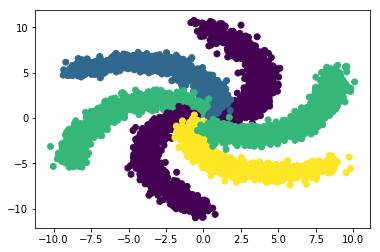

In [100]:
## Creating Data
import numpy as np
import matplotlib.pyplot as plt
def get_spiral():
    # Idea: radius -> low...high
    #           (don't start at 0, otherwise points will be "mushed" at origin)
    #       angle = low...high proportional to radius
    #               [0, 2pi/6, 4pi/6, ..., 10pi/6] --> [pi/2, pi/3 + pi/2, ..., ]
    # x = rcos(theta), y = rsin(theta) as usual

    radius = np.linspace(1, 10, 1000)
    thetas = np.empty((6, 1000))
    for i in range(6):
        start_angle = np.pi*i / 3.0
        end_angle = start_angle + np.pi / 2
        points = np.linspace(start_angle, end_angle, 1000)
        thetas[i] = points

    # convert into cartesian coordinates
    x1 = np.empty((6, 1000))
    x2 = np.empty((6, 1000))
    for i in range(6):
        x1[i] = radius * np.cos(thetas[i])
        x2[i] = radius * np.sin(thetas[i])

    # inputs
    X = np.empty((6000, 2))
    X[:,0] = x1.flatten()
    X[:,1] = x2.flatten()

    # add noise
    X += np.random.randn(6000, 2)*0.5

    # targets
    Y = np.array([0]*1000 + [1]*1000 + [2]*1000 + [0]*1000 + [3]*1000 + [2]*1000)
    return X, Y

X,y=get_spiral()

plt.scatter(X[:,0],X[:,1],c=y)
plt.show()

## Processing the Data

def one_hot_encoder(X):
    N=X.shape[0]
    K=len(np.unique(X))
    Z=np.zeros((N,K))
    for i in range(N):
        c=int(X[i])
        Z[i,c]=1
    return Z
y_i=one_hot_encoder(y)

def standardize(X):
    stds=X.std(axis=0)
    means=X.mean(axis=0)
    X=(X-means)/stds
    return X,means,stds

X_s,m,s=standardize(X)

def train_test_split(X,y,size=0.8,rs=None):
    N=len(X)
    np.random.seed(rs)
    tr_i=np.random.choice(N,int(size*N),replace=False)
    t_i=[i for i in range(N) if i not in tr_i]
    X_train=X[tr_i]
    y_train=y[tr_i]
    X_test=X[t_i]
    y_test=y[t_i]
    return X_train,y_train,X_test,y_test
X_train,y_train,X_test,y_test=train_test_split(X_s,y,size=0.9,rs=20)

X_train=X_train.astype(np.float32)
y_train=y_train.astype(np.float32)
X_test=X_test.astype(np.float32)
y_test=y_test.astype(np.float32)

In [101]:
import theano
from theano import tensor as T

In [102]:
from theano.tensor.nnet.bn import batch_normalization_train,batch_normalization_test

In [103]:
batch_normalization_train()

TypeError: batch_normalization_train() missing 3 required positional arguments: 'inputs', 'gamma', and 'beta'

In [104]:
class HiddenLayer(object):
    def  __init__(self,i,M1,M2,decay=0.99,af='relu',rs=None):
        self.id=i
        self.M1=M1
        self.M2=M2
        self.decay=decay
        self.af=af
        np.random.seed(rs)
        self.W=theano.shared((np.random.randn(M1,M2)/np.sqrt(2.0/M1)),'W{0}'.format(i))
        self.beta=theano.shared(np.zeros(M2),'beta{0}'.format(i))
        self.gamma=theano.shared(np.ones(M2),'gamma{0}'.format(i))
        self.r_m=theano.shared(np.zeros(M2),'r_m{0}'.format(i))
        self.r_v=theano.shared(np.zeros(M2),'r_v{0}'.format(i))
        self.params=[self.W,self.beta,self.gamma]

    def forward(self,X,type='train'):
        X=X.dot(self.W)
        if type=='train':
            X,b_m,b_iv,self.n_r_m,self.n_r_v=batch_normalization_train(X,self.gamma,self.beta,epsilon=1e-5,running_average_factor=(1-self.decay),running_mean=self.r_m,running_var=self.r_v)
            self.r_ups=[(self.r_m,self.n_r_m),(self.r_v,self.n_r_v)]
        else:
            X=batch_normalization_test(X,self.gamma,self.beta,epsilon=1e-5,mean=self.r_m,var=self.r_v)
        if self.af=='sigmoid':
            return T.nnet.sigmoid(X)
        elif self.af=='tanh':
            return T.tanh(X)
        else:
            return T.nnet.relu(X)

In [118]:
class ANN(object):
    def __init__(self,hidden_layer_size,decay=0.999):
        self.hidden_layer_size=hidden_layer_size
        self.decay=decay
    def forward(self,X,type='train'):
        z=X
        if type=='train':
            for h in self.hidden_layers:
                z=h.forward(z,type)
        else:
            for h in self.hidden_layers:
                z=h.forward(z,type)
        return T.nnet.softmax(z.dot(self.W)+self.b)
    def predict(self,X):
        p=self.forward(X,'pred')
        return T.argmax(p,axis=1)
    def fit(self,X,y,af=None,lr=0.001,epochs=1000,mu=0.95,decay=0.999,random_state=None,batch_size=100,fig=True):
#         y=one_hot_encoder(y)
        y=y.astype(np.int32)
        if af==None:
            af=len(self.hidden_layer_size)*['relu']
        X_t,y_t,X_v,y_v=train_test_split(X,y,size=0.9,rs=random_state)
        c_t=[]
        c_v=[]
        cl_t=[]
        cl_v=[]
        N,D=X_t.shape
        self.hidden_layers=[]
        M1=D
        cnt=0
        for M2,a in zip(self.hidden_layer_size,af):
            h=HiddenLayer(i=cnt,M1=M1,M2=M2,af=a,rs=random_state)
            self.hidden_layers.append(h)
            M1=M2
            cnt+=1
        M2=len(set(y))
        self.W=theano.shared(np.random.randn(M1,M2)/np.sqrt(2.0/M1),'W_f')
        self.b=theano.shared(np.zeros(M2),'b_f')
        self.params=[self.W,self.b]
        for h in self.hidden_layers:
            self.params+=h.params
        thX=T.matrix('X')
        thY=T.ivector('y')
        y_p=self.forward(thX)
        cost=-T.mean(T.log(y_p[T.arange(thY.shape[0]),thY]))
        preds=self.predict(thX)
        get_cost_preds=theano.function(inputs=[thX,thY],outputs=[cost,preds])
        grads=T.grad(cost,self.params)
        vparams=[theano.shared(np.zeros_like(p.get_value()),'v{0}'.format(self.params.index(p))) for p in self.params]
        vups=[(v,mu*v-lr*g) for v,g in zip(vparams,grads)]
        updates=[(p,p+mu*v-lr*g) for p,v,g in zip(self.params,vparams,grads)]
        for h in self.hidden_layers:
            updates+=h.r_ups
        updates+=vups
        train=theano.function(inputs=[thX,thY],updates=updates)
        n_batch=int(np.ceil(N/batch_size))
        for i in range(epochs):
            for j in range(n_batch):
                x=X_t[j*batch_size:j*batch_size+batch_size]
                yb=y_t[j*batch_size:j*batch_size+batch_size]
                c,p=get_cost_preds(x,yb)
                c_t.append(c)
                cl_t.append(np.mean(p==yb))
                c,p=get_cost_preds(X_v,y_v)
                c_v.append(c)
                cl_v.append(np.mean(p==y_v))
                train(x,yb)
            if i % 10==0:
                print('Epoch {0} Train C: {1} Cl: {2} Test C: {3} Cl:{4}'.format(i,c_t[i],cl_t[i],c_v[i],cl_v[i]))
        if fig==True:
            plt.plot(c_t,label='Train Cost')
            plt.plot(c_v,label='Test Cost')
            plt.legend()
            plt.show()
            plt.plot(cl_t,label='Train Classification')
            plt.plot(cl_v,label='Test Classification')
            plt.legend()
            plt.show()
    


In [119]:
ann=ANN((500,300))

Epoch 0 Train C: 157.35727169003928 Cl: 0.41 Test C: 181.560612950912 Cl:0.38333333333333336
Epoch 10 Train C: 67.51800787712044 Cl: 0.5 Test C: 80.88727656822387 Cl:0.4740740740740741
Epoch 20 Train C: 52.552162995751516 Cl: 0.43 Test C: 45.9510405573192 Cl:0.46296296296296297
Epoch 30 Train C: 45.58180373222249 Cl: 0.5 Test C: 15.050901821524462 Cl:0.5370370370370371
Epoch 40 Train C: 30.233294968927524 Cl: 0.4 Test C: 11.236427613117822 Cl:0.43333333333333335
Epoch 50 Train C: 21.121399025589767 Cl: 0.39 Test C: 14.618727129588141 Cl:0.40555555555555556
Epoch 60 Train C: 2.629058986024152 Cl: 0.46 Test C: 3.136431220577291 Cl:0.46296296296296297
Epoch 70 Train C: 36.67682760518603 Cl: 0.54 Test C: 15.417985617255935 Cl:0.512962962962963
Epoch 80 Train C: 6.828697675071327 Cl: 0.47 Test C: 5.447860095914354 Cl:0.5296296296296297
Epoch 90 Train C: 22.22140690691489 Cl: 0.59 Test C: 11.445433530192114 Cl:0.5481481481481482
Epoch 100 Train C: 2.8932637900749167 Cl: 0.47 Test C: 15.62443

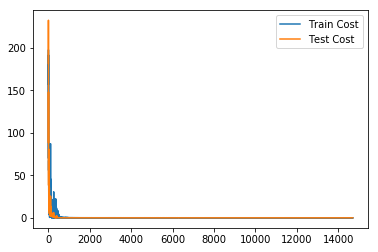

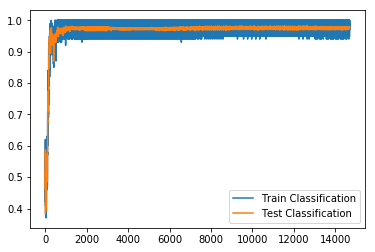

In [120]:
ann.fit(X_train,y_train,lr=0.1,epochs=300)

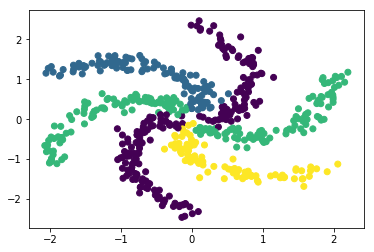

In [121]:
thX=T.matrix('X_test')
preds=ann.predict(thX)
f=theano.function([thX],outputs=preds)

y_p_test=f(X_test)

plt.scatter(X_test[:,0],X_test[:,1],c=y_p_test)
plt.show()